In [1]:
### MANUAL INPUT NEEDED ###

import sys
import os, fnmatch
from functions import *

import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import time
import juliet

root_path = '/Users/mason/data/' # root path for where you want to store outputs
date = '18Jul22' # will be used to create a new folder to store the data in
tag = '' # if you need to add an additional identifier to the folder name

random = np.random.default_rng(47) # fix the random number generator


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Set up transit / LC parameters

In [2]:
### MANUAL INPUT NEEDED ###

### General Manual Inputs ###

# Light curve
cadence = 30       # in minutes
oversample = 11    # amount of oversampling assumed for the data
N_transits = 10    # number of transits to synthesize

# Planet
per_inj = 26.12    # period in days
t0_inj = 1.0       # transit midpoint in days
ror_inj = 0.03     # planet-star radius ratio

# Star
rho_test = rhosun          # stellar density (set to solar)
rho_test_err = rhosun*0.1  # uncertainty in stellar density (set to 10%)
u_vals = [0.4, 0.25]       # quadratic limb darkening coefficients


In [10]:
### MANUAL INPUT NEEDED ###

### Sensitive Manual Inputs ###

snr   = 20      # desired signal-to-noise

b_inj = 0.5     # impact parameter
e_inj = 0.8     # eccentricity
w_inj = pi_2    # omega (in radians)

### Or if you want to select from a grid of inputs, use the code in the cell below instead

In [11]:
##################################################################
######################## ORIGINAL Grid ###########################
##################################################################

if False: # switch to True if you want to select inputs from this grid
    run_num = 25 # change this to select a different point in the grid
    
    b_grid = 1-np.geomspace(0.9,0.1,5)
    snr_grid = np.array([20,40,80])
    e_grid = np.geomspace(0.05,0.8,5)
    w_grid = np.array([pi_2, 132*pi_180, 178*pi_180, 226*pi_180, 3*pi_2])


    points = []

    for ww in w_grid:
        for ss in snr_grid:
            for bb in b_grid:
                for ee in e_grid:
                    point = [bb, ss, ee, ww]
                    points.append(point)


    point = points[int(run_num-1)]

    b_inj, snr, e_inj, w_inj = point


In [12]:
### NO ACTION NEEDED ###

# Computes duration (T14, via Winn 2010 equation) and sigma_noise

dur_inj = calc_T14(per_inj, rho_test, b_inj, ror_inj, e_inj, w_inj)
sigma_noise = calc_noise(dur_inj, N_transits, ror_inj, snr, cadence=cadence)


In [13]:
### NO ACTION NEEDED ###

# Sets up paths and file/folder names

run_params = '-s'+str(snr)+'-b'+str(round(b_inj,2)).ljust(4, '0')+'-e'+str(round(e_inj,2)).ljust(4, '0')+'-w'+str(int(w_inj*180/np.pi)).zfill(3)
folder = 'test_' + date + run_params
dir_path = root_path + date + tag + '/' + folder + '/'

if os.path.isdir(root_path) == False:
    os.mkdir(root_path)

if os.path.isdir(root_path + date + tag + '/') == False:
    os.mkdir(root_path + date + tag + '/')

if os.path.isdir(dir_path) == False:
    os.mkdir(dir_path)



In [14]:
### NO ACTION NEEDED ###

# Puts all input parameters into dictionary

texp = (60.*cadence)/day

TRUTHS = {'PERIOD': per_inj,
         'T0': t0_inj,
         'DUR14': dur_inj,
         'ROR': ror_inj,
         'IMPACT': b_inj,
         'ECC': e_inj,
         'OMEGA': w_inj,
         'SNR': snr,
         'NOISE': sigma_noise,
         'RHOSTAR': rho_test,
         'RHOSTARE': rho_test_err,
         'LD_U1': u_vals[0],
         'LD_U2': u_vals[1],
         'MSTAR': 1.0,
         'RSTAR': 1.0,
         }


# Create (and plot) synthetic LC

In [15]:
### MANUAL INPUT NEEDED ###

width = dur_inj*5 # change this to change size of final window around the transit

In [16]:
### NO ACTION NEEDED ###

# Creates synthetic light curve

n_samples = int((per_inj/texp) * (N_transits - 0.5))
x = np.arange(n_samples)*texp

y = sigma_noise * random.normal(size=n_samples)
yerr = np.full(n_samples, sigma_noise)

light_curve_point = simple_model(x, TRUTHS, oversample=oversample)
y_true = light_curve_point.flatten()
y += light_curve_point.flatten()

print('Created synthetic lightcurve!')


Created synthetic lightcurve!


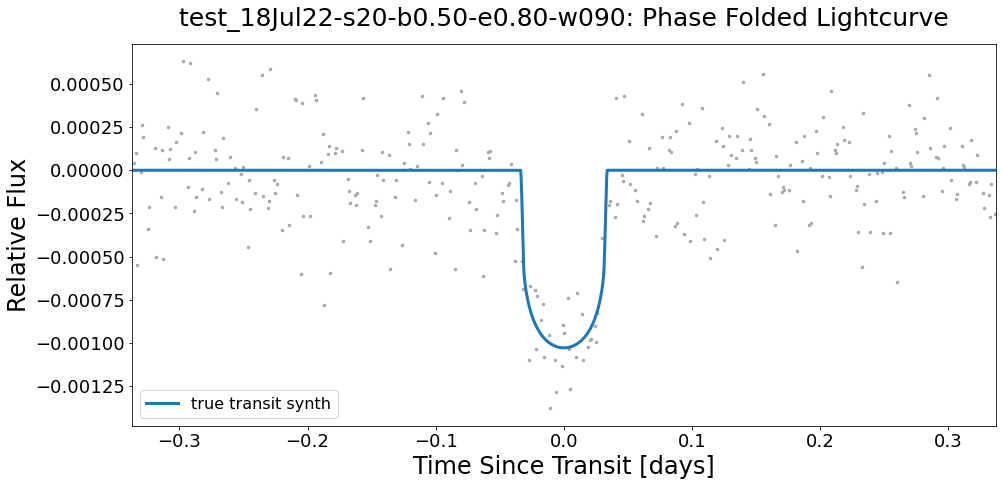

In [17]:
### NO ACTION NEEDED ###

### Plotting code below ###

##### Synth LC fit for display purposes only ########
texp_synth = texp/100
n_samples_synth = int(per_inj/texp_synth)
x_test_synth = np.arange(n_samples_synth)*texp_synth

light_curve_point_synth = simple_model(x_test_synth , TRUTHS, synth=True, oversample=oversample)
y_true_synth = light_curve_point_synth.flatten()

x_fold_synth = (x_test_synth - t0_inj + 0.5*per_inj)%per_inj - 0.5*per_inj
m_synth = np.abs(x_fold_synth) < width
#####################################################

x_fold = (x - t0_inj + 0.5*per_inj)%per_inj - 0.5*per_inj
m = np.abs(x_fold) < width

fig = plt.figure(figsize=(14, 7))
plt.rc('text', usetex=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Relative Flux", fontsize=24)
plt.xlabel("Time Since Transit [days]", fontsize=24)

plt.plot(x_fold[m], y[m], color='darkgrey', ls='', marker='.')
plt.plot((x_test_synth-t0_inj)[m_synth], y_true_synth[m_synth], lw=3, label='true transit synth')
plt.legend(fontsize=16)

title = folder + ": " + "Phase Folded Lightcurve"
plt.title(title, fontsize=25, y=1.03)
plt.xlim(-width, width)
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig(dir_path + folder + '-folded_lc.png')
plt.show()

In [18]:
### NO ACTION NEEDED ###

# Finlizes the synthetic light curve data

x_fin, y_fin, yerr_fin = x[m], y[m], yerr[m]

data_df = pd.DataFrame()
data_df['X'] = x_fin
data_df['Y'] = y_fin
data_df['Y_ERR'] = yerr_fin

data_df.to_csv(dir_path + folder + '-lc_data.csv')


# Set up and run *juliet* (using *dynesty* and *batman*)

In [19]:
### MANUAL INPUT NEEDED ###

# Define the master prior dictionary. First define the TRANSIT priors:
priors = {}

# Convert limb darkening coefficients from u to q (Kipping 2013; https://arxiv.org/pdf/1308.0009.pdf)
u1 = TRUTHS['LD_U1']
u2 = TRUTHS['LD_U2']
q1 = (u1+u2)**2
q2 = u1 / (2*(u1+u2))

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','q1_KEPLER','q2_KEPLER','ecc_p1','omega_p1',\
              'T14_p1', 'mdilution_KEPLER', 'mflux_KEPLER', 'sigma_w_KEPLER']

# Distribution for each of the parameters:
dists = ['fixed','normal','loguniform','uniform','fixed','fixed','fixed','fixed',\
                 'loguniform', 'fixed', 'fixed', 'fixed']


# Set prior boundaries
RORMIN = 0.0001
RORMAX = 1.0

DURMIN = 0.0001
DURMAX = 1.0

# Hyperparameters of the distributions (mean and standard-deviation for normal
# distributions, lower and upper limits for uniform and loguniform distributions, and
# fixed values for fixed "distributions", which assume the parameter is fixed)
hyperps = [TRUTHS['PERIOD'], [TRUTHS['T0'], 0.1], [RORMIN, RORMAX], [0,1+RORMAX], q1, q2, 0., 90.,\
                   [DURMIN, DURMAX], 1.0, 0., TRUTHS['NOISE']]


# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp




In [21]:
### MANUAL INPUT NEEDED ###

# Set desired hyperparameters for nested sampling model
n_live_points = 5000
n_effective   = 10000
dlogz  = 0.001
ecclim = 0.99

# Load data into juliet
times, fluxes, fluxes_error = {},{},{}
t, f, ferr = x_fin, y_fin, yerr_fin
times['KEPLER'], fluxes['KEPLER'], fluxes_error['KEPLER'] = t,f+1,ferr

dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                   yerr_lc = fluxes_error,
                   out_folder = dir_path + folder + '-n'+str(n_live_points)) 



In [22]:
### NO ACTION NEEDED ###

# Now time to fit 
t0=time.time()
results = dataset.fit(sampler='dynesty', ecclim=ecclim,
                      n_live_points=n_live_points, n_effective=n_effective, dlogz=dlogz, 
                      lc_instrument_supersamp=['KEPLER'], 
                      lc_n_supersamp=[oversample], 
                      lc_exptime_supersamp=[texp], 
                      verbose=False)

t1=time.time()
print('time to complete (seconds):', t1-t0)



73347it [12:36, 96.98it/s, +5000 | bound: 78 | nc: 1 | ncall: 1544550 | eff(%):  5.089 | loglstar:   -inf < 2227.352 <    inf | logz: 2211.500 +/-    nan | dlogz:  0.001 >  0.001]


n_effective: 10000.084058049757
time to complete (seconds): 759.1510920524597


# Results

In [25]:
### NO ACTION NEEDED ###

# Save outputs to a pandas dataframe
old_cols = ['loglike', 'p_p1', 'b_p1', 'T14_p1']
new_cols = ['LN_LIKE', 'ROR', 'IMPACT', 'DUR14']

trace_df = pd.DataFrame()

print('Effective sample sizes (according to arviz):')
for i, col in enumerate(new_cols):
    old_col = old_cols[i]
    trace_df[col] = results.posteriors['posterior_samples'][old_col]
    if col != 'LN_LIKE':
        print(col + ': ', az.ess(trace_df[col].values))

trace_df.to_csv(dir_path + folder + '-samples' + '-time_' + str(round(t1-t0,2))+'s' + '.csv')

#### I still do not understand why dynesty says that the # of effective samples is big but arviz says it is small..?
#### if you could figure out why this is, please let me know!

Effective sample sizes (according to arviz):
ROR:  9.741953567815678
IMPACT:  9.845500166134444
DUR14:  9.658797045724882


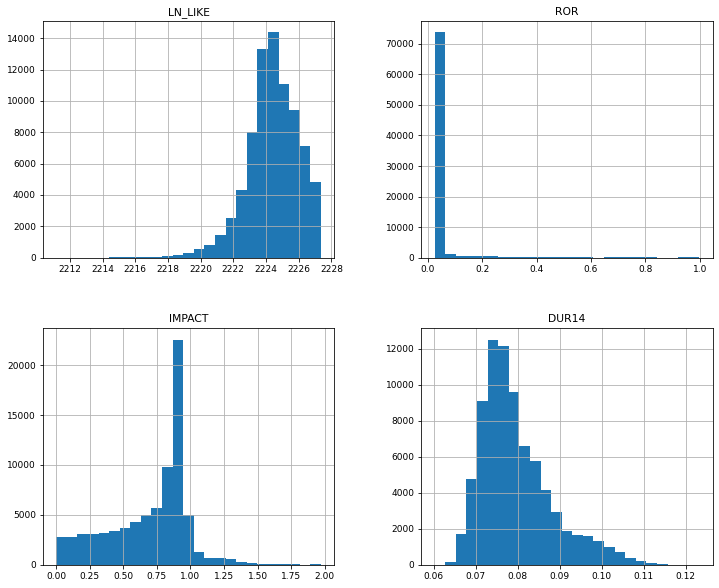

In [26]:
### NO ACTION NEEDED ###

# Plots the data

trace_df.hist(figsize=(12,10), bins=25);